# **Pratical Assignment for Data Mining II**

**General description:**

You are given a dataset comprised of 18k tweets about the last U.S. Presidential election, which were retrieved before the election was held. The tweets are already labeled as TRUE or FALSE in the field
`questionable_domain`. 

The ultimate goal of this project is for you to create a classification system for tweets in order to identify where a new (unseen) tweet is disseminating questionable information, or not.

## Load data

### Load data and split the dataframe

First step is to load the `tweets.csv` file and make a 85/15 split for the hidden set.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.model_selection import train_test_split

url = 'https://raw.githubusercontent.com/sofiamalpique/fcup-data-mining-ii/main/tweets.csv'
df = pd.read_csv(url)

tweets, hidden = train_test_split(df, test_size=0.15, random_state = 42)

Now that split is done, we should retrieve all the possible information from our dataframe called `tweets`.

We're interested in checking what are the most common ***words***, ***@mentions***, ***#hashtags*** and ***URLs*** for tweets with `questionable_domain` TRUE and for tweets with `questionable_domain` FALSE.

## Retrieving Information

Separete the tweets:

In [ ]:
true_tweets = tweets.loc[tweets['questionable_domain'] == 0]
fake_tweets = tweets.loc[tweets['questionable_domain'] == 1]

### Word count

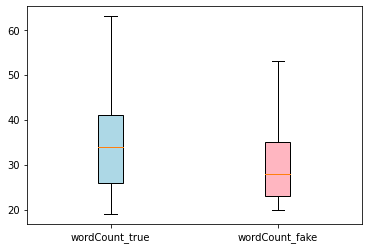

       wordCount_fake
count     2537.000000
mean        30.144659
std          9.184747
min         20.000000
25%         23.000000
50%         28.000000
75%         35.000000
max         86.000000
       wordCount_true
count    12720.000000
mean        34.217374
std          9.147935
min         19.000000
25%         26.000000
50%         34.000000
75%         41.000000
max         99.000000


In [ ]:
import matplotlib.pyplot as plt

def get_word_count(tweet):
  return len(tweet.split(" "))
true_words_count = list(true_tweets["description"].apply(get_word_count))
fake_words_count = list(fake_tweets["description"].apply(get_word_count))

wordCount_dic = {"wordCount_true":true_words_count,"wordCount_fake":fake_words_count}

box = plt.boxplot(wordCount_dic.values(),showfliers=False, patch_artist=True)
plt.xticks([1, 2], ['wordCount_true', 'wordCount_fake'])
colors = ['lightblue', 'lightpink']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

print(pd.DataFrame(fake_words_count,columns=["wordCount_fake"]).describe())
print(pd.DataFrame(true_words_count,columns=["wordCount_true"]).describe())

### URLs

In [ ]:
from urllib.parse import urlparse
import re
import requests

def searchUrl(tweet):
  ans = re.search("(?P<url>https?://[^\s]+)",tweet).group("url")
  return ans

def convertDomain(url):
  if url != '':
    resp = requests.head(url)
    resp.status_code
    if 'Location' in resp.headers:
      long_link = resp.headers['Location']
      parsed_uri = urlparse(long_link)  # returns six components
      domain = '{uri.netloc}/'.format(uri=parsed_uri)
      return domain[:-1]
    else:
      return ''
  else:
    return url

In [ ]:
# It will take around 20 minutes

tu = list(true_tweets['description'].apply(searchUrl))
fu = list(fake_tweets['description'].apply(searchUrl))

tu = [convertDomain(url) for url in tu]
fu = [convertDomain(url) for url in fu]

In [ ]:
tu = [link.replace('www.','') for link in tu]
fu = [link.replace('www.','') for link in fu]

#print(tu)
#print(len(tu))
#print(fu)
#print(len(fu))

# We will check if there is any URL in common
to_delete = list(set(tu).intersection(fu))
#print(to_delete)

good_urls = tu
bad_urls = fu

for link in good_urls:
  if link in to_delete:
    good_urls.remove(link)

for link in bad_urls:
  if link in to_delete:
    bad_urls.remove(link)

Making a wordcloud of root domains for "good" tweets

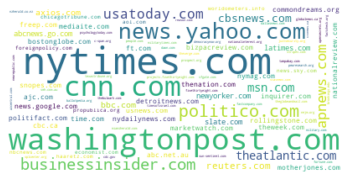

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

d = {x:tu.count(x) for x in tu}

true_word_cloud = WordCloud(background_color='white').generate_from_frequencies(d)

plt.imshow(true_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Making a wordcloud of root domains for "bad" tweets

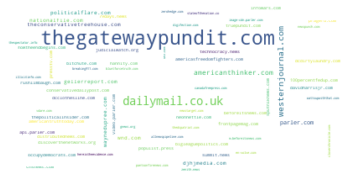

In [ ]:
d = {x:fu.count(x) for x in fu}

fake_word_cloud = WordCloud(background_color='white').generate_from_frequencies(d)

plt.imshow(fake_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Hashtags

In [ ]:
def getHashtags(tweet):
  ans = re.findall(r"#(\w+)", tweet)
  return ans

true_hashtags = list(true_tweets['description'].apply(getHashtags))
for hash in true_hashtags:
  if hash == []:
    true_hashtags.remove(hash)
true_hashtags = [item for sublist in true_hashtags for item in sublist]
# Put all in lowercase
thl=[]
for hash in true_hashtags:
  thl.append(hash.lower())


fake_hashtags = list(fake_tweets['description'].apply(getHashtags))
for hash in fake_hashtags:
  if hash == []:
    fake_hashtags.remove(hash)
fake_hashtags = [item for sublist in fake_hashtags for item in sublist]
# Put all in lowercase
fhl=[]
for hash in fake_hashtags:
  fhl.append(hash.lower())


# FAKE
data = {"hashs": fhl}

fake_df = pd.DataFrame(data)
fake_df = fake_df.value_counts().rename_axis('unique_values').reset_index(name='counts_fake')

# TRUE
data = {"hashs": thl}

true_df = pd.DataFrame(data)
true_df = true_df.value_counts().rename_axis('unique_values').reset_index(name='counts_true')

# ALL
all_hashtags_df = pd.merge(fake_df,true_df, on='unique_values', how='outer')
all_hashtags_df['counts_true'] = all_hashtags_df['counts_true'].fillna(0)
all_hashtags_df['counts_fake'] = all_hashtags_df['counts_fake'].fillna(0)

lf = []
for i in range(len(all_hashtags_df)):
  value = all_hashtags_df['counts_fake'][i] / (all_hashtags_df['counts_fake'][i]+all_hashtags_df['counts_true'][i])
  lf.append(value)

all_hashtags_df['hashtags_fake_percentage'] = lf

lt = []
for i in range(len(all_hashtags_df)):
  value = all_hashtags_df['counts_true'][i] / (all_hashtags_df['counts_fake'][i]+all_hashtags_df['counts_true'][i])
  lt.append(value)

all_hashtags_df['hashtags_true_percentage'] = lt


#print(all_hashtags_df.loc[all_hashtags_df['counts_fake'] >= 5].sort_values(by=["hashtags_fake_percentage","counts_fake"],ascending=False)[:15])
#print(all_hashtags_df.loc[all_hashtags_df['counts_true'] >= 25].sort_values(by=["hashtags_true_percentage","counts_true"],ascending=False)[:])

interesting_hashs_1 = all_hashtags_df.loc[(all_hashtags_df['counts_fake'] >= 5) & (all_hashtags_df['hashtags_fake_percentage'] >=0.90)]
fake_hash_list = list(interesting_hashs_1['unique_values'])
print("Most interesting fake Hashtags:")
print(fake_hash_list)


interesting_hashs_2 = all_hashtags_df.loc[(all_hashtags_df['counts_true'] >= 25) & (all_hashtags_df['hashtags_true_percentage'] >=0.90)]
true_hash_list = list(interesting_hashs_2['unique_values'])
print("Most interesting true Hashtags:")
print(true_hash_list)


Most interesting fake Hashtags:
['aag', 'aag2020', 'nevertrumper', 'ricothedems', 'impeachobamasjudges', 'arrestthemallnow', '8217', 'cnntapes', 'bidencheated', 'neonnettle']
Most interesting true Hashtags:
['trump', 'covid19', 'smartnews', 'bidenharris', 'bidenharris2020', 'covid', 'elections2020', 'vote', 'trumpvirus', 'coronavirus', 'democracy', 'republicans', 'trumpisanationaldisgrace', 'gopcorruptionovercountry', 'moscowmitch', 'trumpmeltdown', 'gopcomplicittraitors', 'votebluetosaveamerica', 'gopbetrayedamerica', 'trumpisalaughingstock']


Hashtags count Analysis

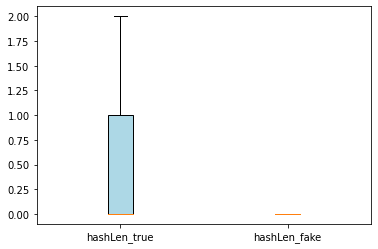

       hashLen_fake
count   2537.000000
mean       0.479306
std        1.652257
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       25.000000
       hashLen_true
count  12720.000000
mean       0.635220
std        1.742379
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       30.000000


In [ ]:
def getHashtags(tweet):
  ans = re.findall(r"#(\w+)", tweet)
  return ans

my_fake_tweets = fake_tweets[:]
my_true_tweets = true_tweets[:]

# Creating a new column of mentions of that tweet
my_fake_tweets['hashtags'] = my_fake_tweets['description'].apply(getHashtags)
my_fake_tweets['hashtags_count'] = my_fake_tweets['hashtags'].apply(len)
my_fake_tweets = list(my_fake_tweets.hashtags_count)

my_true_tweets['hashtags'] = my_true_tweets['description'].apply(getHashtags)
my_true_tweets['hashtags_count'] = my_true_tweets['hashtags'].apply(len)
my_true_tweets = list(my_true_tweets.hashtags_count)


hashLen_dic = {"hashLen_true":my_true_tweets,"hashLen_fake":my_fake_tweets}


box = plt.boxplot(hashLen_dic.values(),showfliers=False, patch_artist=True)
plt.xticks([1, 2], ['hashLen_true', 'hashLen_fake'])
colors = ['lightblue', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

print(pd.DataFrame(my_fake_tweets,columns=["hashLen_fake"]).describe())
print(pd.DataFrame(my_true_tweets,columns=["hashLen_true"]).describe())

Making a wordcloud of the "bad" hashtags

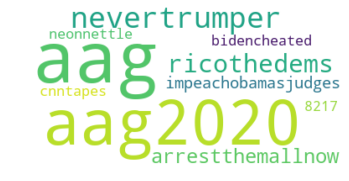

In [ ]:
nfhl = [i for i in fhl if i in fake_hash_list]
d = {x:nfhl.count(x) for x in nfhl}

fake_word_cloud = WordCloud(background_color='white').generate_from_frequencies(d)

plt.imshow(fake_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Making a wordclud of the "good" hashtags

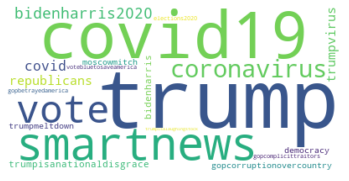

In [ ]:
nthl = [i for i in thl if i in true_hash_list]
d = {x:nthl.count(x) for x in nthl}

true_word_cloud = WordCloud(background_color='white').generate_from_frequencies(d)

plt.imshow(true_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Mentions

In [ ]:
def getMentions(tweet):
  res = []
  ans = re.findall("(^|[^@\w])@(\w{1,15})", tweet)
  for item in ans:
    res.append(item[1])
  return res

true_mentions = list(true_tweets['description'].apply(getMentions))
for mention in true_mentions:
  if mention == []:
    true_mentions.remove(mention)
true_mentions = [item for sublist in true_mentions for item in sublist]
# Put all in lowercase
tml=[]
for mention in true_mentions:
  tml.append(mention.lower())


fake_mentions = list(fake_tweets['description'].apply(getMentions))
for mention in fake_mentions:
  if mention == []:
    fake_mentions.remove(mention)
fake_mentions = [item for sublist in fake_mentions for item in sublist]
# Put all in lowercase
fml=[]
for mention in fake_mentions:
  fml.append(mention.lower())


# FAKE
data = {"mentions": fml}

fake_df = pd.DataFrame(data)
fake_df = fake_df.value_counts().rename_axis('unique_values').reset_index(name='counts_fake')

# TRUE
data = {"mentions": tml}

true_df = pd.DataFrame(data)
true_df = true_df.value_counts().rename_axis('unique_values').reset_index(name='counts_true')

# ALL
all_mentions_df = pd.merge(fake_df,true_df, on='unique_values', how='outer')
all_mentions_df['counts_fake'] = all_mentions_df['counts_fake'].fillna(0)
all_mentions_df['counts_true'] = all_mentions_df['counts_true'].fillna(0)


lf = []
for i in range(len(all_mentions_df)):
  value = all_mentions_df['counts_fake'][i] / (all_mentions_df['counts_fake'][i]+all_mentions_df['counts_true'][i])
  lf.append(value)

all_mentions_df['mentions_fake_percentage'] = lf


lt = []
for i in range(len(all_mentions_df)):
  value = all_mentions_df['counts_true'][i] / (all_mentions_df['counts_fake'][i]+all_mentions_df['counts_true'][i])
  lt.append(value)

all_mentions_df['mentions_true_percentage'] = lt


#print(all_mentions_df.loc[all_mentions_df['counts_fake'] >= 25].sort_values(by=["mentions_fake_percentage","counts_fake"],ascending=False)[:20])
#print(all_mentions_df.loc[all_mentions_df['counts_true'] >= 150].sort_values(by=["mentions_true_percentage","counts_true"],ascending=False)[:20])


interesting_mentions_1 = all_mentions_df.loc[(all_mentions_df['counts_fake'] >= 25) & (all_mentions_df['mentions_fake_percentage'] >=0.90)]
fake_mention_list = list(interesting_mentions_1['unique_values'])
#print(fake_mention_list)

interesting_mentions_2 = all_mentions_df.loc[(all_mentions_df['counts_true'] >= 150) & (all_mentions_df['mentions_true_percentage'] >=0.90)]
true_mention_list = list(interesting_mentions_2['unique_values'])
#print(true_mention_list)

Mention count Analysis

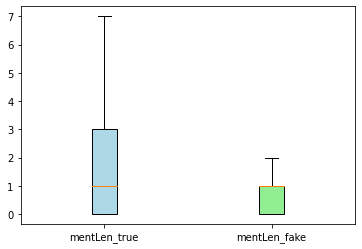

       mentLen_fake
count   2537.000000
mean       2.608199
std        5.825761
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max       50.000000
       mentLen_true
count  12720.000000
mean       2.448506
std        4.612939
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       50.000000


In [ ]:
my_fake_tweets = fake_tweets[:]
my_true_tweets = true_tweets[:]

# Creating a new column of mentions of that tweet
my_fake_tweets['mentions'] = my_fake_tweets['description'].apply(getMentions)
my_fake_tweets['mentions_count'] = my_fake_tweets['mentions'].apply(len)
my_fake_tweets = list(my_fake_tweets.mentions_count)

my_true_tweets['mentions'] = my_true_tweets['description'].apply(getMentions)
my_true_tweets['mentions_count'] = my_true_tweets['mentions'].apply(len)
my_true_tweets = list(my_true_tweets.mentions_count)


mentLen_dic = {"mentLen_true":my_true_tweets,"mentLen_fake":my_fake_tweets}

box = plt.boxplot(mentLen_dic.values(),showfliers=False, patch_artist=True)
plt.xticks([1, 2], ['mentLen_true', 'mentLen_fake'])
colors = ['lightblue', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

fmdf = pd.DataFrame(my_fake_tweets,columns=["mentLen_fake"])
print(fmdf.describe())
tmdf = pd.DataFrame(my_true_tweets,columns=["mentLen_true"])
print(tmdf.describe())

Making a wordcloud of "good" mentions

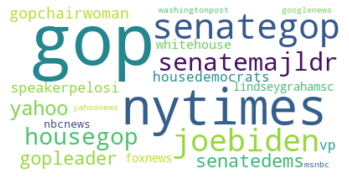

In [ ]:
ntml = [i for i in tml if i in true_mention_list]
d = {x:ntml.count(x) for x in ntml}

true_word_cloud = WordCloud(background_color='white').generate_from_frequencies(d)

plt.imshow(true_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Making a wordcloud of "bad" mentions

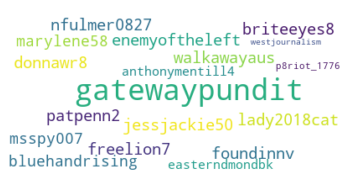

In [ ]:
nfml = [i for i in fml if i in fake_mention_list]
d = {x:nfml.count(x) for x in nfml}

fake_word_cloud = WordCloud(background_color='white').generate_from_frequencies(d)

plt.imshow(fake_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Words

In [ ]:
######### Prepare text functions #########

from nltk.stem import WordNetLemmatizer

def capsCount(tweet):
  tw = removePonctuation(tweet)
  tw = lemmatizeSentence(tw)
  tw = tw.split(" ")
  tw = [i for i in tw if i.isupper()]
  return len(tw)

def removePonctuation(text):
  ans = re.sub(r'[^\w\s]', '', text)
  return ans

def removeUrl(tweet):
  ans = re.sub(r'http\S+', '', tweet)
  return ans

def removeMentions(tweet):
  ans = re.sub(r'@\S+', '', tweet)
  return ans

def removeHashtags(tweet):
  ans = re.sub(r'#\S+', '', tweet)
  return ans

def removeStopWords(text):
  text_tokens = nltk.tokenize.word_tokenize(text)
  tokens_without_sw = [word for word in text_tokens if not word in nltk.corpus.stopwords.words()]
  filtered_sentence = (" ").join(tokens_without_sw)
  return filtered_sentence


lemmatizer = WordNetLemmatizer()
def getWordnetPOS(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatizeSentence(text):
  ans = [lemmatizer.lemmatize(w, getWordnetPOS(w)) for w in nltk.word_tokenize(text)]
  lemmatized_output = ' '.join(ans)
  return lemmatized_output

Let's proceed to an analysis of the most used words in these tweets

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


In [ ]:
fake_description = fake_tweets['description']
fake_description_list = list(fake_description)

A = ' '.join(fake_description_list)
A = removeUrl(A)
A = removeMentions(A)
A = removeHashtags(A)
A = removePonctuation(A)
A = removeStopWords(A)
A = lemmatizeSentence(A)
A = A.split(' ')
A = [i.lower() for i in A]

data = {"words": A}

fake_df = pd.DataFrame(data)
fake_df = fake_df.value_counts().rename_axis('unique_values').reset_index(name='counts_fake')


true_description = true_tweets['description']
true_description_list = list(true_description)

B = ' '.join(true_description_list)
B = removeUrl(B)
B = removeMentions(B)
B = removeHashtags(B)
B = removePonctuation(B)
B = removeStopWords(B)
B = lemmatizeSentence(B)
B = B.split(' ')
B = [i.lower() for i in B]


data = {"words": B}

true_df = pd.DataFrame(data)
true_df = true_df.value_counts().rename_axis('unique_values').reset_index(name='counts_true')
true_df


all_description_df = pd.merge(fake_df,true_df, on='unique_values', how='outer')
all_description_df
all_description_df['counts_fake'] = all_description_df['counts_fake'].fillna(0)
all_description_df['counts_true'] = all_description_df['counts_true'].fillna(0)


lf = []
for i in range(len(all_description_df)):
  value = all_description_df['counts_fake'][i] / (all_description_df['counts_fake'][i]+all_description_df['counts_true'][i])
  lf.append(value)

all_description_df['word_fake_percentage'] = lf


lt = []
for i in range(len(all_description_df)):
  value = all_description_df['counts_true'][i] / (all_description_df['counts_fake'][i]+all_description_df['counts_true'][i])
  lt.append(value)

all_description_df['word_true_percentage'] = lt


#print(all_description_df.loc[all_description_df['counts_fake'] >= 25].sort_values(by=["word_fake_percentage","counts_fake"],ascending=False)[:20])
#print(all_description_df.loc[all_description_df['counts_true'] >= 150].sort_values(by=["word_true_percentage","counts_true"],ascending=False)[:20])



interesting_words_1 = all_description_df.loc[(all_description_df['counts_fake'] >= 25) & (all_description_df['word_fake_percentage'] >=0.9)]
iw_1 = list(interesting_words_1['unique_values'])


interesting_words_2 = all_description_df.loc[(all_description_df['counts_true'] >= 150) & (all_description_df['word_true_percentage'] >=0.9)]
iw_2 = list(interesting_words_2['unique_values'])

interesting_words = iw_1+iw_2

Making a wordcloud of the "bad" words

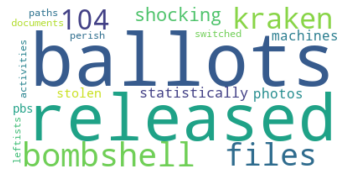

In [ ]:
nA = [i for i in A if i in iw_1]
d = {x:nA.count(x) for x in nA}

fake_word_cloud = WordCloud(background_color='white').generate_from_frequencies(d)

plt.imshow(fake_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Making a wordcloud of the "good" words

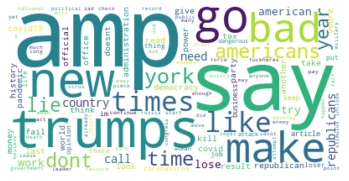

In [ ]:
nB = [i for i in B if i in iw_2]
d = {x:nB.count(x) for x in nB}

true_word_cloud = WordCloud(background_color='white').generate_from_frequencies(d)

plt.imshow(true_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Box plot of words

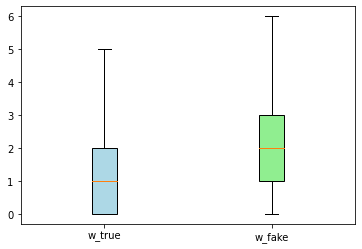

In [ ]:
w_fake = [i.split(" ") for i in fake_description_list]
w_fake2 = []
for i in w_fake:
  w_fake2.append([removePonctuation(j) for j in i])
w_fake = []
for i in w_fake2:
  w_fake.append([lemmatizeSentence(j) for j in i])


w1 = []
for i in w_fake:
  w1.append(len([j for j in i if j.isupper()]))


w_true = [i.split(" ") for i in true_description_list]
w_true2 = []
for i in w_true:
  w_true2.append([removePonctuation(j) for j in i])
w_true = []
for i in w_true2:
  w_true.append([lemmatizeSentence(j) for j in i])


w2 = []
for i in w_true:
  w2.append(len([j for j in i if j.isupper()]))


caps_dic = {"w_true":w2,"w_fake":w1}

box = plt.boxplot(caps_dic.values(),showfliers=False, patch_artist=True)
plt.xticks([1, 2], ['w_true', 'w_fake'])
colors = ['lightblue', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

#print(DataFrame(w1,columns=["w_fake"]).describe())
#print(DataFrame(w2,columns=["w_true"]).describe())


## Pre-processing 

### Auxiliar Functions

In [ ]:
!pip3 install text2emotion
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
import text2emotion as te

def capsCount(tweet):
  tw = removePonctuation(tweet)
  tw = lemmatizeSentence(tw)
  tw = tw.split(" ")
  tw = [i for i in tw if i.isupper()]
  return len(tw)

def gatewaypunditInTweet(mentions_list):
  if "gatewaypundit" in mentions_list:
    return 1
  return 0

# counts how many words a string has
def countWord(string):
  s = string.split(' ')
  return len(s)

# removes a URL from a string
def removeUrl(tweet):
  ans = re.sub(r'http\S+', '', tweet)
  return ans

# gives us a list of @mentions
def getMentions(tweet):
  res = []
  ans = re.findall("(^|[^@\w])@(\w{1,15})", tweet)
  for item in ans:
    res.append(item[1])
  return res

# gets list of #wordtags
def getHashtags(tweet):
  ans = re.findall(r"#(\w+)", tweet)
  return ans

# converts bool to 0/1
def boolToBinary(value):
  if value == False:
    return 0
  else:
    return 1

# checks if url is in bad_urls list
def containsBadURLs(url):
  if url in bad_urls:
    return 1
  else:
    return 0

# checks if url is in good_urls list
def containsGoodURLs(url):
  if url in good_urls:
    return 1
  else:
    return 0

# checks if mention is in fake_mention_list
def containsBadMentions(mentions_list):
  for mention in mentions_list:
    if mention in fake_mention_list:
      return 1
  return 0

# checks if mention is in true_mention_list
def containsGoodMentions(mentions_list):
  for mention in mentions_list:
    if mention in true_mention_list:
      return 1
  return 0

# checks if hash is in fake_hash_list
def containsBadHashtags(hashtags_list):
  for hash in hashtags_list:
    if hash in fake_hash_list:
      return 1
  return 0

# checks if hash is in true_hash_list
def containsGoodHashtags(hashtags_list):
  for hash in hashtags_list:
    if hash in true_hash_list:
      return 1
  return 0

# checks if word is in fake_word_list
def containsBadWords(words_list):
  for word in words_list:
    if word in iw_1:
      return 1
  return 0

# checks if word is in true_word_list
def containsGoodWords(words_list):
  for word in words_list:
    if word in iw_2:
      return 1
  return 0


sia = SentimentIntensityAnalyzer()
def sentimentAnalysis(text):
  return sia.polarity_scores(text)["compound"]


def getAngryLevel(text):
  return te.get_emotion(text)['Angry']

def getFearLevel(text):
  return te.get_emotion(text)['Fear']

def getHappyLevel(text):
  return te.get_emotion(text)['Happy']

def getSadLevel(text):
  return te.get_emotion(text)['Sad']

def getSurpriseLevel(text):
  return te.get_emotion(text)['Surprise']


### pre-processing function

In [ ]:
def preProcessing(df):

  # Removing unecessary features
  df = df.drop(['id','title'], axis=1)

  # Creating a new column name taht gives us the number of words in a tweet
  df['word_count'] = df['description'].apply(countWord)

  # Creating new column 'url'
  df['url'] = df['description'].apply(searchUrl)
  df['url'] = df['url'].apply(convertDomain)

  # Updating 'description' column
  df['description'] = df['description'].apply(removeUrl)

  # Creating a new column of mentions of that tweet
  df['mentions'] = df['description'].apply(getMentions)
  df['contains_gatewaypundit'] = df['mentions'].apply(gatewaypunditInTweet)

  # Creating a new column of hashtags of that tweet
  df['hashtags'] = df['description'].apply(getHashtags)

  df['mentions_count'] = df['mentions'].apply(len)

  df['hashtags_count'] = df['hashtags'].apply(len)

  df['Caps_count'] = df['description'].apply(capsCount)

  # Switching 'False' for 0 and 'True' for 1
  df['contains_profanity'] = df['contains_profanity'].apply(boolToBinary)
  df['questionable_domain'] = df['questionable_domain'].apply(boolToBinary)
  df['user_verified'] = df['user_verified'].apply(boolToBinary)


  df['contains_bad_url'] = df['url'].apply(containsBadURLs)
  df['contains_good_url'] = df['url'].apply(containsGoodURLs)

  df['contains_bad_mentions'] = df['mentions'].apply(containsBadMentions)
  df['contains_good_mentions'] = df['mentions'].apply(containsGoodMentions)

  df['contains_bad_hashtags'] = df['hashtags'].apply(containsBadHashtags)
  df['contains_good_hashtags'] = df['hashtags'].apply(containsGoodHashtags)


  ##### Taking care of the text #####

  # Removing ponctuation from 'description'
  df['description'] = df['description'].apply(removePonctuation)

  # Puting everything lowercase
  df['description'] = df['description'].apply(str.lower)

  # Removing StopWords
  df['description'] = df['description'].apply(removeStopWords)

  # Doing Lemmatization
  df['description'] = df['description'].apply(lemmatizeSentence)

  # Sentiment Analysis
  df['sentiment_analysis'] = df['description'].apply(sentimentAnalysis)

  df['contains_bad_words'] = df['description'].apply(containsBadWords)
  df['contains_good_words'] = df['description'].apply(containsGoodWords)

  df['angry_level'] = df['description'].apply(getAngryLevel)

  df['fear_level'] = df['description'].apply(getFearLevel)

  df['happy_level'] = df['description'].apply(getHappyLevel)

  df['sad_level'] = df['description'].apply(getSadLevel)

  df['surprise_level'] = df['description'].apply(getSurpriseLevel)


  df = df.drop(['url','mentions','description','hashtags'], axis = 1)

  return df

RUNNING THE CELL BELLOW WILL TAKE 2 TO 3 HOURS

In [ ]:
tweets = preProcessing(tweets)

In [ ]:
'''
from google.colab import files
tweets.to_csv('tweets_afterPP.csv') 
files.download('tweets_afterPP.csv')
'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Run this instead

Given the fact that the pre-processing step would take plenty of time, we've already done it and we make it available in the cell below. 👇 

In [ ]:
url = 'https://raw.githubusercontent.com/sofiamalpique/fcup-data-mining-ii/main/tweets_afterPP.csv'
tweets = pd.read_csv(url)
del tweets['Unnamed: 0']

## Feature Importance

Performing a Feature Importance to know which features can be deleted

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

features_names = tweets.columns.values.tolist()
data = tweets

# Create Dependent and Independent Datasets based on our Dependent 
# feature (target)

X = data.loc[:, data.columns != 'questionable_domain']

y = data['questionable_domain']

# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, y)

importance_list = list(model.feature_importances_)


a = features_names[1:]
b = importance_list

c = zip(a,b)
c = list(c)

d = sorted(c, key = lambda x: x[1])

to_delete = []
for i in range(len(d)):
  if d[i][1] <= 0.01:
    to_delete.append(d[i][0])

print(to_delete)

['contains_bad_words', 'contains_good_hashtags', 'contains_bad_hashtags', 'contains_profanity', 'user_verified', 'contains_good_mentions', 'contains_good_words']


Deleting the non-important features

In [ ]:
tweets = tweets.drop(to_delete, axis=1)

## Machine Learning

### Initializing ML Algorithms

In [ ]:
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
nb_classifier = GaussianNB()
rf_classifier = RandomForestClassifier(n_estimators=100)
adb_classifier = AdaBoostClassifier(n_estimators=100)
vot_classifier = VotingClassifier(estimators=[('adb', adb_classifier), ('rf', rf_classifier), ('nb', nb_classifier)], voting='hard')

# Creating a list of classifiers so we can iterate on it
classifiers = [nb_classifier, rf_classifier, adb_classifier, vot_classifier]

On the original 85% of the dataframe that we decided to work with, we are now taking care of the imbalancement that exists, so we can better train our model.

### Imbalanced Data

We have imbalanced data, so we should perform under-sampling of the abundant/majority class, and perform over-sampling of the minority class

In [ ]:
#check out how many fake and true cases we have:
print(tweets['questionable_domain'].value_counts())

0    12720
1     2537
Name: questionable_domain, dtype: int64


In [ ]:
tt = tweets.loc[tweets['questionable_domain'] == 0]
ft = tweets.loc[tweets['questionable_domain'] == 1]

Over-sampling

In [ ]:
q_subset = ft.sample(frac=0.5)
q_subset = pd.concat([q_subset, ft], axis=0)

Under-sampling

In [ ]:
nq_subset = tt.sample(n=len(q_subset))

Creating an even dataframe, i.e. with the same number of "fake" and "true" tweets

In [ ]:
even_dataframe = pd.concat([nq_subset, q_subset])


We should shuffle them, so that we don't have all 1s after all 0s

In [ ]:
even_dataframe = even_dataframe.sample(frac = 1, random_state = 1).reset_index()
del even_dataframe['index']

At this point we have an even dataframe with as much true cases as fake cases so the model doesn't have any tendency.

Now, we need to separate the target feature from the rest of the dataframe

In [ ]:
X_train = even_dataframe.loc[:, even_dataframe.columns != 'questionable_domain']
y_train = even_dataframe['questionable_domain']

for clf in classifiers:

  scores = cross_val_score(clf, X_train, y_train, cv=10, scoring = 'accuracy')
  a1 = sum(list(scores))/10
  scores = cross_val_score(clf, X_train, y_train, cv=10, scoring = 'precision')
  a2 = sum(list(scores))/10
  scores = cross_val_score(clf, X_train, y_train, cv=10, scoring = 'recall')
  a3 = sum(list(scores))/10
  scores = cross_val_score(clf, X_train, y_train, cv=10, scoring = 'f1')
  a4 = sum(list(scores))/10

  print()
  print('With cross validation:')
  print('CV - {} accuracy:'.format(clf),a1)
  print('CV - {} precision:'.format(clf),a2)
  print('CV - {} recall:'.format(clf),a3)
  print('CV - {} f1:'.format(clf),a4)
  print()
  


With cross validation:
CV - GaussianNB() accuracy: 0.6207621550591327
CV - GaussianNB() precision: 0.6069025654781756
CV - GaussianNB() recall: 0.7543721508495648
CV - GaussianNB() f1: 0.6611756459412084


With cross validation:
CV - RandomForestClassifier() accuracy: 0.9195795006570302
CV - RandomForestClassifier() precision: 0.951277281667301
CV - RandomForestClassifier() recall: 0.8856858682138418
CV - RandomForestClassifier() f1: 0.9166526091862528


With cross validation:
CV - AdaBoostClassifier(n_estimators=100) accuracy: 0.8169513797634691
CV - AdaBoostClassifier(n_estimators=100) precision: 0.8730174228175306
CV - AdaBoostClassifier(n_estimators=100) recall: 0.7419242989363172
CV - AdaBoostClassifier(n_estimators=100) f1: 0.8020081100018412


With cross validation:
CV - VotingClassifier(estimators=[('adb', AdaBoostClassifier(n_estimators=100)),
                             ('rf', RandomForestClassifier()),
                             ('nb', GaussianNB())]) accuracy: 0.8629434

In [ ]:
rf_classifier.fit(X_train,y_train)

## Chosing the Classifier

### Evaluation of Scores

Given the results above, the "winner" classifier is 

```
rf_classifier = RandomForestClassifier(n_estimators=100)
```


So, what we need to do at this stage is to use it in our hidden dataframe to assess how "good" it actually is (giving it unseen data).


 1.   We need to pre-process the hidden set so that it will have the exact same features that our (even) dataframe has.

In [ ]:
# This will take about 30 minutes

hidden_after_preProcessing = preProcessing(hidden)

In [ ]:
'''
from google.colab import files
hidden_after_preProcessing.to_csv('hidden_afterPP.csv') 
files.download('hidden_afterPP.csv')
'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Given the waiting time, we decided to have run it before and now make it availale in the cell bellow so we can skip the previous step.

In [ ]:
url = 'https://raw.githubusercontent.com/sofiamalpique/fcup-data-mining-ii/main/hidden_afterPP.csv'
hidden_after_preProcessing = pd.read_csv(url)
del hidden_after_preProcessing['Unnamed: 0']

Remember that we dropped all the least important features? Here we also need to dropped them, so that they can have the same number of features.

In [ ]:
hidden_after_preProcessing = hidden_after_preProcessing.drop(to_delete, axis = 1)

At this point the only thing left to do is to apply our "chosen" classifier:

In [ ]:
X = hidden_after_preProcessing.loc[:, hidden_after_preProcessing.columns != 'questionable_domain']
y = hidden_after_preProcessing['questionable_domain']

#rf_classifier.fit(X, y)
rf_classifier_preds = rf_classifier.predict(X)

print("################################# RESULTS OF OUR WINNER MODEL USING HIDDEN #################################")
print()
print("with a single hold out:")
print('{} accuracy:'.format(rf_classifier),metrics.accuracy_score(y, y_pred = rf_classifier_preds))
print('{} precision:'.format(rf_classifier),metrics.precision_score(y, y_pred = rf_classifier_preds))
print('{} recall:'.format(rf_classifier),metrics.recall_score(y, y_pred = rf_classifier_preds))
print('{} f1:'.format(rf_classifier),metrics.f1_score(y, y_pred = rf_classifier_preds))
print()

################################# RESULTS OF OUR WINNER MODEL USING HIDDEN #################################

with a single hold out:
RandomForestClassifier() accuracy: 0.9220200519866321
RandomForestClassifier() precision: 0.7962529274004684
RandomForestClassifier() recall: 0.734341252699784
RandomForestClassifier() f1: 0.7640449438202248

################################# RESULTS OF OUR WINNER MODEL USING HIDDEN #################################

with a single hold out:
RandomForestClassifier() accuracy: 0.9220200519866321
RandomForestClassifier() precision: 0.7962529274004684
RandomForestClassifier() recall: 0.734341252699784
RandomForestClassifier() f1: 0.7640449438202248

